In [2]:
# =============================================================================
# Main script to run a full end-to-end example for the abcnre package.
# This script covers:
# 1. Setting up a simulation environment for a Gaussian model.
# 2. Saving the simulator's configuration.
# 3. Creating a neural network and training configuration.
# 4. Training the Neural Ratio Estimator.
# 5. Saving all training artifacts (weights, samples, config).
# 6. Loading the artifacts and performing diagnostics by comparing the
#    NRE posterior to the true analytical posterior.
# =============================================================================

import jax
import jax.numpy as jnp
import numpy as np
import yaml
import matplotlib.pyplot as plt
from pathlib import Path

# --- Imports from abcnre package ---
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import GaussGaussModel
from abcnre.simulation.utils import save_simulator, load_simulator

from abcnre.inference.config import ExperimentConfig, get_experiment_config
from abcnre.inference.estimator import NeuralRatioEstimator
from abcnre.inference.networks.base import create_network_from_config
from abcnre.inference.persistence import save_classifier, load_classifier


# --- Step 1: Create and Configure Simulator ---
print("--- Step 1: Create and Configure Simulator ---")
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)

# Define ground truth and model parameters
true_theta = 2.5
model_sigma = 0.5
prior_mean = 0.0
prior_std = 2.0
n_observations = 100

# Generate synthetic observed data
observed_data = true_theta + model_sigma * jax.random.normal(subkey, shape=(n_observations,))
gauss_model = GaussGaussModel(mu0=prior_mean, sigma0=prior_std, sigma=model_sigma)

# Instantiate the main ABCSimulator
simulator = ABCSimulator(
    model=gauss_model,
    observed_data=observed_data,
    quantile_distance=0.05  # Automatically find a good epsilon
)
print(f"Simulator created with epsilon = {simulator.epsilon:.4f}")

# --- Step 2: Save Simulator Configuration ---
print("\n--- Step 2: Save Simulator Configuration ---")
output_dir = Path("./gauss_example")
output_dir.mkdir(exist_ok=True, parents=True)
simulator_path = output_dir / "gauss_1D_simulator.yml"
simulator.save(simulator_path)
print(f"Simulator config saved to: {simulator_path}")

# --- Step 3: Create Network and Training Configuration ---
print("\n--- Step 3: Create Network Configuration ---")
# Use the factory to get a pre-defined configuration
experiment_config = get_experiment_config('default_mlp_plateau')
# Customize it for our specific experiment
experiment_config.training.num_epochs = 50
experiment_config.training.n_samples_per_epoch = 10240

network_config_path = output_dir / "config_mlp_reduce_on_plateau.yml"
experiment_config.save(network_config_path)
print(f"Training configuration saved to: {network_config_path}")


# --- Step 4: Training the Classifier ---
print("\n--- Step 4: Training the Classifier ---")
# Load the configs and simulator needed for training
exp_config = ExperimentConfig.load(network_config_path)
exp_config.training.num_thetas_to_store = 10000
experiment_config.training.num_epochs = 50
experiment_config.training.n_samples_per_epoch = 2048
loaded_simulator = ABCSimulator.load(simulator_path)

# Create the network and estimator objects
network = create_network_from_config(exp_config.network.to_dict())
estimator = NeuralRatioEstimator(
    network=network,
    training_config=exp_config.training,
    random_seed=exp_config.random_seed
)
print(f"Estimator created with '{exp_config.network.network_type}' network.")

# Run the training process
key, train_key = jax.random.split(key)
training_results = estimator.train(
    simulator=loaded_simulator,
    output_dir=output_dir,
    num_epochs=exp_config.training.num_epochs,
    n_samples_per_epoch=exp_config.training.n_samples_per_epoch,
    batch_size=exp_config.training.batch_size
)
print("✅ Training complete.")

# --- Step 5: Saving All Classifier Artifacts ---
print("\n--- Step 5: Saving All Classifier Artifacts ---")
# This single function saves weights, phis, and the master config
final_config_path = save_classifier(
    estimator=estimator,
    output_dir=output_dir,
    filename_base="gauss_1D",
    simulator=loaded_simulator,
)


--- Step 1: Create and Configure Simulator ---
Computing epsilon for 5.0% quantile...
Computed epsilon = 0.283647
Simulator created with epsilon = 0.2836

--- Step 2: Save Simulator Configuration ---
✅ Simulator saved with hash: 273b7710f945
   - Configuration: gauss_example/gauss_1D_simulator.yml
   - Observed Data: gauss_example/observed_data_273b7710f945.npy
Simulator config saved to: gauss_example/gauss_1D_simulator.yml

--- Step 3: Create Network Configuration ---
Training configuration saved to: gauss_example/config_mlp_reduce_on_plateau.yml

--- Step 4: Training the Classifier ---
✅ Simulator loaded from: gauss_example/gauss_1D_simulator.yml
Estimator created with 'MLPNetwork' network.
Initialized network with 10,753 parameters

--- DEBUG INFO ---
Does epoch_data contain phi_samples? True
Shape of phi_samples: (5120, 1)
--- END DEBUG INFO ---

Epoch 1/50 | Train Loss: 0.6811, Val Loss: 0.6852, Train Acc 54.30%, Val Acc: 51.12%, Learning rate = 0.001000
Epoch 2/50 | Train Loss: 0

In [2]:
# =============================================================================
# Main script to run a full end-to-end example for the abcnre package.
# =============================================================================

import jax
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Imports from abcnre package ---
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import GaussGaussModel
from abcnre.inference.config import ExperimentConfig, get_experiment_config
from abcnre.inference.estimator import NeuralRatioEstimator
from abcnre.inference.networks.base import create_network_from_config
from abcnre.inference.persistence import save_classifier, load_classifier
from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_posterior
from abcnre.diagnostics.viz import plot_posterior_comparison

# --- Step 1: Create and Configure Simulator ---
print("--- Step 1: Create and Configure Simulator ---")
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)

true_theta = 2.5
gauss_model = GaussGaussModel(mu0=0.0, sigma0=2.0, sigma=0.5)
observed_data = true_theta + gauss_model.sigma * jax.random.normal(subkey, shape=(100,))

simulator = ABCSimulator(
    model=gauss_model,
    observed_data=observed_data,
    quantile_distance=0.05
)
print(f"Simulator created with epsilon = {simulator.epsilon:.4f}")

# --- Step 2: Save Simulator Configuration ---
print("\n--- Step 2: Save Simulator Configuration ---")
output_dir = Path("./gauss_example")
output_dir.mkdir(exist_ok=True, parents=True)
simulator_path = output_dir / "gauss_1D_simulator.yml"
simulator.save(simulator_path)
print(f"Simulator config saved to: {simulator_path}")

# --- Step 3: Create Network and Training Configuration ---
print("\n--- Step 3: Create Network Configuration ---")
exp_config = get_experiment_config('default_mlp_plateau')
exp_config.training.num_epochs = 50
exp_config.training.n_samples_per_epoch = 1240
exp_config.training.num_thetas_to_store = 10000

network_config_path = output_dir / "config_mlp_reduce_on_plateau.yml"
exp_config.save(network_config_path)
print(f"Training configuration saved to: {network_config_path}")

# --- Step 4: Training the Classifier ---
print("\n--- Step 4: Training the Classifier ---")
loaded_simulator = ABCSimulator.load(simulator_path)
network = create_network_from_config(exp_config.network.to_dict())
estimator = NeuralRatioEstimator(
    network=network,
    training_config=exp_config.training,
    random_seed=exp_config.random_seed
)

key, train_key = jax.random.split(key)
estimator.train(
    simulator=loaded_simulator,
    output_dir=output_dir,
    num_epochs=exp_config.training.num_epochs,
    n_samples_per_epoch=exp_config.training.n_samples_per_epoch,
    batch_size=exp_config.training.batch_size
)
print("✅ Training complete.")

# --- Step 5: Saving All Classifier Artifacts ---
print("\n--- Step 5: Saving All Classifier Artifacts ---")
final_config_path = save_classifier(
    estimator=estimator,
    simulator=loaded_simulator, # <<< On passe le simulateur pour sauvegarder les dimensions
    output_dir=output_dir,
    filename_base="gauss_1D"
)

--- Step 1: Create and Configure Simulator ---
Computing epsilon for 5.0% quantile...
Computed epsilon = 0.283647
Simulator created with epsilon = 0.2836

--- Step 2: Save Simulator Configuration ---
✅ Simulator saved with hash: 273b7710f945
   - Configuration: gauss_example/gauss_1D_simulator.yml
   - Observed Data: gauss_example/observed_data_273b7710f945.npy
Simulator config saved to: gauss_example/gauss_1D_simulator.yml

--- Step 3: Create Network Configuration ---
Training configuration saved to: gauss_example/config_mlp_reduce_on_plateau.yml

--- Step 4: Training the Classifier ---
✅ Simulator loaded from: gauss_example/gauss_1D_simulator.yml
Initialized network with 10,753 parameters

--- DEBUG INFO ---
Does epoch_data contain phi_samples? True
Shape of phi_samples: (5120, 1)
--- END DEBUG INFO ---

Epoch 1/50 | Train Loss: 0.6811, Val Loss: 0.6852, Train Acc 54.30%, Val Acc: 51.12%, Learning rate = 0.001000
Epoch 2/50 | Train Loss: 0.6771, Val Loss: 0.6708, Train Acc 48.83%, Va


--- Step 6: Diagnostics and Visualization ---
Initialized network with 10,753 parameters
✅ Classifier loaded from gauss_example/gauss_1D_classifier.yml
✅ Estimator loaded. Final validation accuracy: 0.818
✅ Simulator loaded from: gauss_example/gauss_1D_simulator.yml
Diagnostic plot saved to gauss_example/posterior_comparison.png


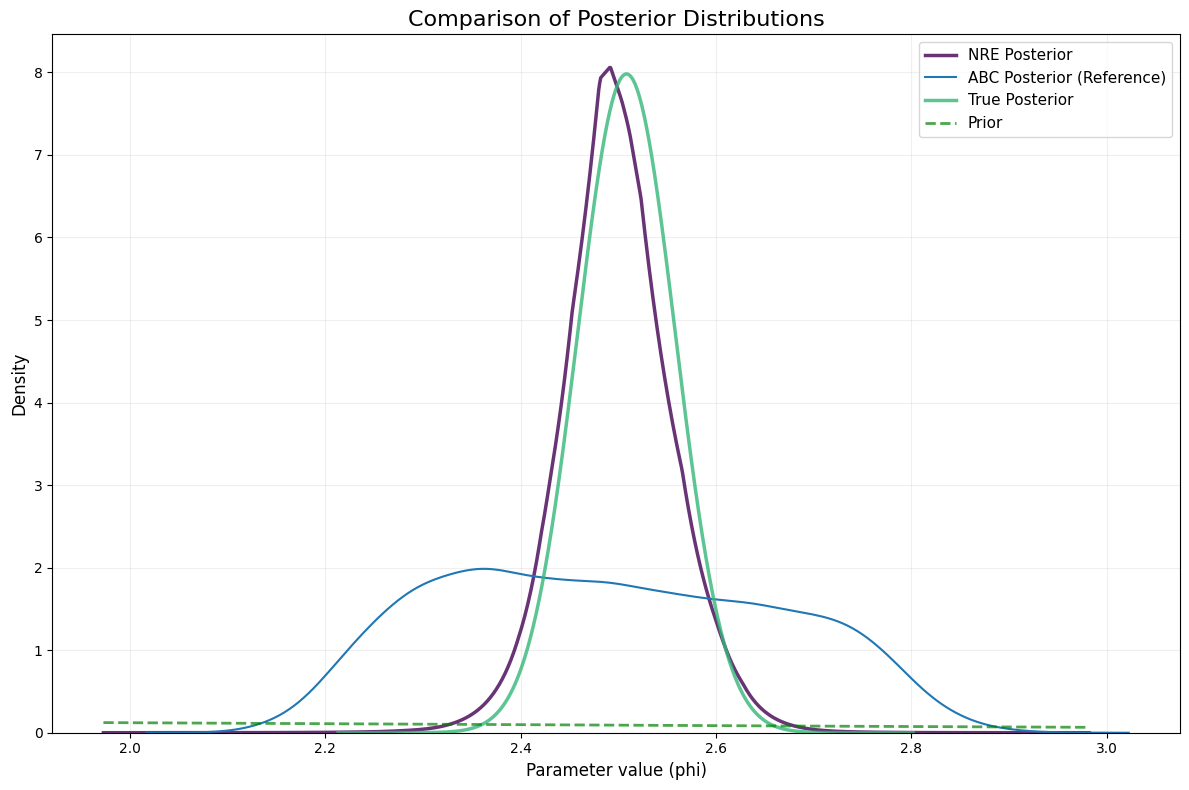


✅ Diagnostics complete.


In [7]:
import jax
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Imports from abcnre package ---
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import GaussGaussModel
from abcnre.inference.config import ExperimentConfig, get_experiment_config
from abcnre.inference.estimator import NeuralRatioEstimator
from abcnre.inference.networks.base import create_network_from_config
from abcnre.inference.persistence import save_classifier, load_classifier
from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_posterior
from abcnre.diagnostics.viz import plot_posterior_comparison

output_dir = Path("./gauss_example")
final_config_path = output_dir / "gauss_1D_classifier.yml"
# --- Step 6: Diagnostics and Visualization ---
print("\n--- Step 6: Diagnostics and Visualization ---")
loaded_estimator, abc_phi_samples, metrics = load_classifier(final_config_path)
print(f"✅ Estimator loaded. Final validation accuracy: {metrics.get('final_val_accuracy', -1):.3f}")

loaded_simulator = ABCSimulator.load(output_dir / "gauss_1D_simulator.yml")
# Get posterior distributions
unnormalized_pdf_func = get_unnormalized_nre_pdf(loaded_estimator, loaded_simulator)
phi_grid, nre_pdf = get_normalized_posterior(unnormalized_pdf_func, initial_bounds=(-5, 10))

# Get prior for plotting
prior_pdf_values = loaded_simulator.model.prior_pdf(phi_grid)

true_grid, true_pdf = get_normalized_posterior(loaded_simulator.model.get_posterior_distribution(loaded_simulator.observed_data).pdf, initial_bounds=(-5, 10))
# Generate the comparison plot
plot_posterior_comparison(
    distributions={'NRE Posterior': (phi_grid, nre_pdf), 'ABC Posterior (Reference)': abc_phi_samples, 'True Posterior': (true_grid, true_pdf)},
    prior_pdf=(phi_grid, prior_pdf_values),
    save_path=output_dir / "posterior_comparison.png"
)

print("\n✅ Diagnostics complete.")

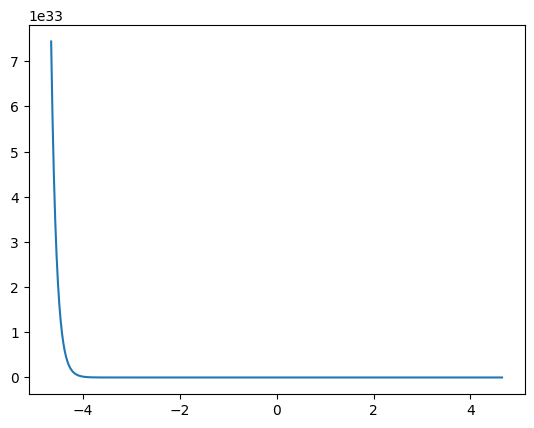

In [3]:
unnormalized_pdf_func = get_unnormalized_nre_pdf(loaded_estimator, loaded_simulator)
prior_dist = simulator.model.prior_dist()
grid_phi = np.linspace(prior_dist.ppf(0.01), prior_dist.ppf(0.99), 1000)
nre_pdf = unnormalized_pdf_func(grid_phi)
plt.plot(grid_phi, nre_pdf, label='NRE PDF')

(1000,)
Diagnostic plot saved to gauss_example/posterior_comparison.png


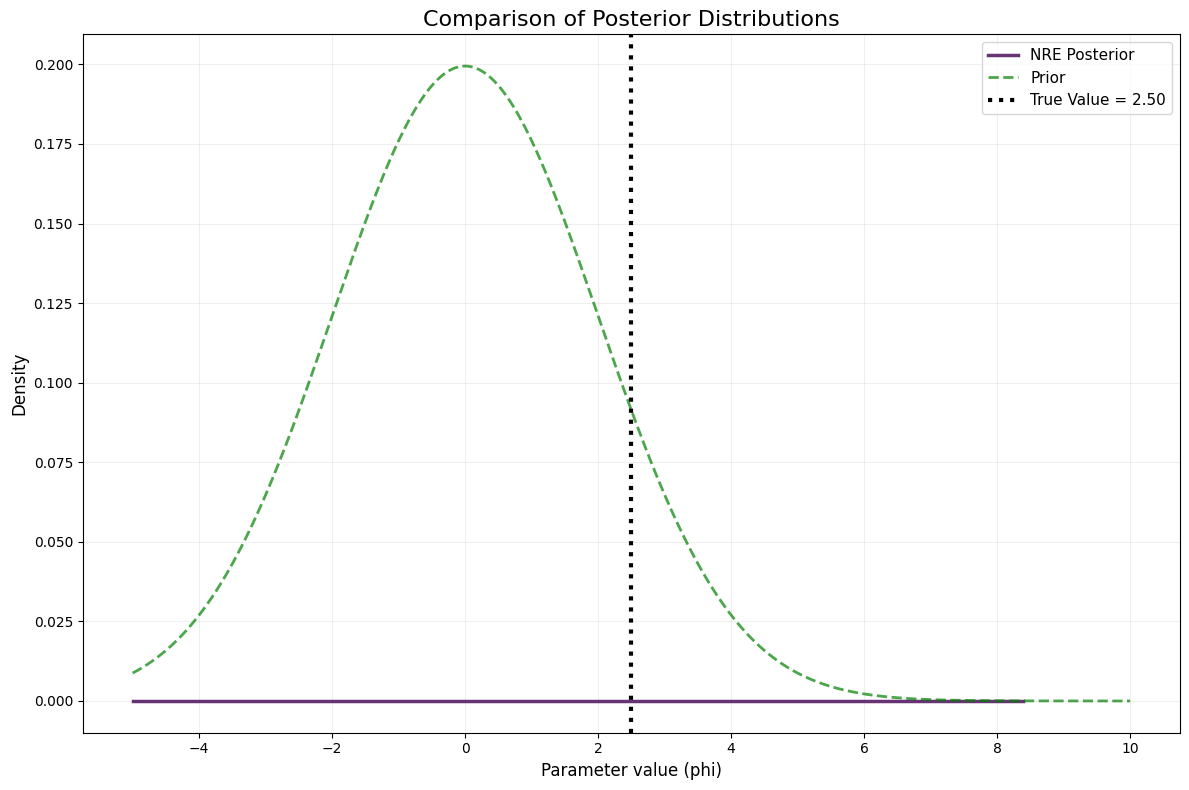


✅ Diagnostics complete.


In [3]:
prior_pdf_values = simulator.model.prior_pdf(phi_grid)

print(prior_pdf_values.shape)
# Generate the comparison plot
plot_posterior_comparison(
    distributions={'NRE Posterior': (phi_grid, nre_pdf), 'ABC Posterior (Reference)': abc_phi_samples},
    prior_pdf=(phi_grid, prior_pdf_values),
    true_value=true_theta,
    save_path=output_dir / "posterior_comparison.png"
)

print("\n✅ Diagnostics complete.")